## Uncertainty quantification and spatial prediction
### *(General flow structure, not finished)*

Some funcions uses the SciKit-GStat module:<br>
Mirko Mälicke, Egil Möller, Helge David Schneider, & Sebastian Müller. (2021, May 28).<br>
    mmaelicke/scikit-gstat: A scipy flavoured geostatistical variogram analysis toolbox (Version v0.6.0).<br>
    Zenodo. http://doi.org/10.5281/zenodo.4835779

In [1]:
# EXTERNAL DEPENDENCIES

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from scipy.linalg import cholesky
from scipy.stats import norm
from scipy.spatial import distance_matrix
from scipy.optimize import curve_fit
from skgstat import Variogram

##### <ins>Step 1</ins>: Generate 2D Seismic Section Representing a Salt Dome

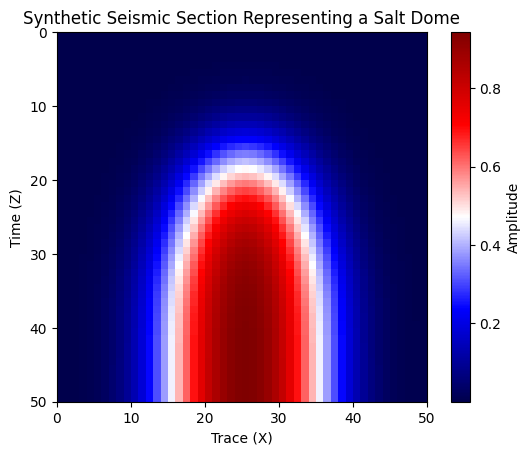

In [2]:
# 2D grid for seismic section
n_rows, n_cols = 50, 50
seismic_data = np.zeros((n_rows, n_cols))


## Salt dome, circular region
dome_center = (45, 25)  # Center of the dome (row, column)
dome_width = 10          # Width of the dome (horizontal extent)
dome_depth = 30          # Depth to which the dome extends
# Create the salt dome using a parabolic shape
for i in range(n_rows):
    for j in range(n_cols):
        # Calculate the distance from the dome center
        distance = np.sqrt(((i - dome_center[0]) / dome_depth) ** 2 + ((j - dome_center[1]) / dome_width) ** 2)
        # Define a parabolic shape for the dome
        if distance < 1:  # Only consider points within the dome boundary
            # Assign a value based on the distance to create a dome effect
            seismic_data[i, j] = 1.0 #* (1 - distance)  # Tapering effect


# Smoothing, to represent realistic seismic reflection
seismic_data = gaussian_filter(seismic_data, sigma=5)


# Plot
plt.imshow(seismic_data, cmap='seismic', extent=[0, n_cols, n_rows, 0])
plt.colorbar(label='Amplitude')
plt.title('Synthetic Seismic Section Representing a Salt Dome')
plt.xlabel('Trace (X)')
plt.ylabel('Time (Z)')
plt.show()


##### <ins>Step 2</ins>: Apply Gaussian Process Regression for Uncertainty Quantification

##### <ins>Step 3</ins>: Apply Sequential Gaussian Simulation Using Covariance Matrix

##### <ins>Step 4</ins>: Apply Sequential Gaussian Simulation Using a Variogram

##### Notes

Gaussian Process Regression produces smooth predictions with uncertainty estimates based on a covariance kernel.<br>
SGS with Covariance Matrix produces random realizations based on a predefined covariance structure, allowing for uncertainty quantification.<br>
SGS with Variogram models the spatial relationship between points, incorporating local structure into the simulations.